# Imports

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

from visualize import *
from data_treatments import *
from feature_selection import *
from models import *

from tp.competitive_learning import *
from tp.linear_model import *
from tp.rbfn import *

# Load data

In [2]:
X1 = pd.read_csv("../data/X1.csv") # [7684 rows x 15 columns]
Y1 = pd.read_csv("../data/Y1.csv",sep='\t',names=["Label"]) # [7684 rows x 1 columns]
X2 = pd.read_csv("../data/X2.csv") # [3787 rows x 15 columns]

# X1 = X1.values # converting pandas dataframe to a numpy array

# Visualize data

In [3]:
#visualize(X1, Y1, 'data.png', True) 

# Data treatments

In [4]:
# step 1 : handle cyclic values

X1_handled = handlecyclic(X1) # handle month, day, hour and wd cyclic features
X1_handled = handle_station(X1_handled) # handle station feature
X1_handled = add_linear_time(X1_handled) # add a global linear time (with year, month, day, hour features)

print(X1_handled.shape)



(7684, 34)


# Visualize new data

In [5]:
#visualize(X1_handled, Y1, 'new_data.PNG', True) 

# Data Splitting

In [6]:
# use of random_state parameter ?
X_train_valid, X_test, Y_train_valid, Y_test = train_test_split(X1_handled, Y1, test_size=0.2, random_state=0)

print(X_train_valid.shape)
print(X_test.shape)
print(Y_train_valid.shape)
print(Y_test.shape)

(6147, 34)
(1537, 34)
(6147, 1)
(1537, 1)


# Normalisation/Standardisation

In [7]:
from scipy.stats import shapiro

'''This funciton takes a imput a dataframe and return a list of the features that are not normal (with threshold alpha)'''
#list = isnormal(X_train_valid)


'This funciton takes a imput a dataframe and return a list of the features that are not normal (with threshold alpha)'

In [8]:
# normalization
[X_norm, X_norm_test] = norm(X_train_valid, X_test)

X_norm = pd.DataFrame(X_norm)
X_norm.columns = X_train_valid.columns

X_norm_test = pd.DataFrame(X_norm_test)
X_norm_test.columns = X_test.columns

# standardisation
[X_stand,X_stand_test] = stand(X_train_valid, X_test, False)
X_stand = pd.DataFrame(X_stand)
X_stand.columns = X_train_valid.columns

X_stand_test = pd.DataFrame(X_stand_test)
X_stand_test.columns = X_test.columns

# robust scaler (outliers)
[X_trans,X_trans_test] = robust_scaler(X_train_valid, X_test)
X_trans = pd.DataFrame(X_trans)
X_trans.columns = X_train_valid.columns
X_trans_test = pd.DataFrame(X_trans_test)
X_trans_test.columns = X_test.columns



# Feature selection

### with standardisation

In [ ]:
# feature selection

# previously
'''
n = 7 # number of feature to select
most_mi = print_mutual_information(X1_handled, X_stand.values, Y_train_valid.values.ravel(), 10)
a = len(most_mi)
index_selected = most_mi[a-n:a]
print(index_selected)
X1 = X_stand.values[:,index_selected]
X1_test = X_stand_test.values[:,index_selected]
'''

features = features_selection(X_stand, Y_train_valid.values.ravel(), 7)
X_selected_stand = X_stand[features]
X_test_selected_stand = X_stand_test[features]


print(X_selected_stand.columns)
#print(X_test_selected.columns)

### with robut_scaler

In [9]:
features = features_selection(X_trans, Y_train_valid.values.ravel(), 7)
X_selected_trans = X_trans[features]
X_test_selected_trans = X_trans_test[features]
print(X_selected_trans.columns)

Index(['DEWP', 'wd_sin', 'NO2', 'O3', 'time', 'SO2', 'mnth_cos', 'PRES',
       'WSPM', 'hr_sin', 'TEMP', 'CO'],
      dtype='object')


# Dimensionality reduction (instead of feature selection) using PCA

In [ ]:
from sklearn.decomposition import PCA

#pca = PCA()
pca = PCA(n_components=10)
pca.fit_transform(X_trans)

print(pca.explained_variance_ratio_)
print("pca.explained_variance_ratio_ = ", np.sum(pca.explained_variance_ratio_))


# Building model

In [10]:
def build_model(X_train, Y_train, X_test, Y_test, model):
    rmse = 1000
    
    if model[0]=='linear_regression_tp':
        rmse = linear_regression_tp(X_train, Y_train, X_test, Y_test)
    
    elif model[0] =='rbfn_tp':
        rmse = rbfn_tp(X_train, Y_train, X_test, Y_test, model[1], model[2])
    
    elif model[0] =='KNN':
        rmse = KNN(X_train, Y_train, X_test, Y_test)
    
    elif model[0] =='linear_regression':
        rmse = linear_regression(X_train, Y_train, X_test, Y_test)
    
    elif model[0] =='tree':
        rmse = tree(X_train, Y_train, X_test, Y_test)
    
    elif model[0] =='random_forest':
        rmse = random_forest(X_train, Y_train, X_test, Y_test)
    
    elif model[0] =='MLperceptron':
        rmse = MLperceptron(X_train, Y_train, X_test, Y_test)
    
    elif model[0] =='SVM':
        rmse = SVM(X_train, Y_train, X_test, Y_test)
    
    else:
        print('incorrect value for model')
    return rmse
    
    

# Performance of the models

### with standardisation

In [ ]:
rmse = build_model(X_selected_stand, Y_train_valid, X_test_selected_stand, Y_test, ['rbfn_tp', [20, 30, 40], [4,8]])
rmse # 41.109355030141586 # with stand, X_test_selected

In [ ]:
rmse = build_model(X_selected_stand, Y_train_valid, X_test_selected_stand, Y_test, ['linear_regression_tp'])
rmse # 45.81350958024227 # with stand, X_test_selected
# 46.555418705773626 # with norm, X_test_selected

In [ ]:
rmse_knn = build_model(X_selected_stand, Y_train_valid, X_test_selected_stand, Y_test, ['KNN'])
rmse_knn # 41.25390056831065 # with stand, X_test_selected
# 45.50425826121668 # with norm, X_test_selected

In [ ]:
rmse_lin_reg = build_model(X_selected_stand, Y_train_valid, X_test_selected_stand, Y_test, ['linear_regression'])
rmse_lin_reg # 45.813509580242275 # with stand, X_test_selected
# 46.55541870577369 # with norm, X_test_selected

In [ ]:
rmse_tree = build_model(X_selected_stand, Y_train_valid, X_test_selected_stand, Y_test, ['tree'])
rmse_tree
# very time expensive


In [ ]:
rmse_rf = build_model(X_selected_stand, Y_train_valid, X_test_selected_stand, Y_test, ['random_forest'])
rmse_rf 

In [ ]:
rmse_mlp = build_model(X_selected_stand, Y_train_valid, X_test_selected_stand, Y_test, ['MLperceptron'])
rmse_mlp 

In [ ]:
rmse_svm = build_model(X_selected_stand, Y_train_valid, X_test_selected_stand, Y_test, ['SVM'])
rmse_svm 

### With robust_scaler

In [11]:
[rmse, rmses_train, rmses_test] = build_model(X_selected_trans, Y_train_valid, X_test_selected_trans, Y_test, ['rbfn_tp', [20, 30, 40], [4,8]])
rmse # 40.12111959245933

n_center =  20
smooth_f =  4
smooth_f =  8
n_center =  30
smooth_f =  4
smooth_f =  8
n_center =  40
smooth_f =  4
smooth_f =  8


40.12111959245933

{20: [44.69186952672285, 44.12552475066397], 30: [42.40075574508107, 42.19663102716723], 40: [41.05928887440521, 41.341601881755864]}
{20: [43.251395441565016, 42.249180404859864], 30: [40.90223948205746, 40.68938827951188], 40: [39.86338901143768, 40.12237325861007]}


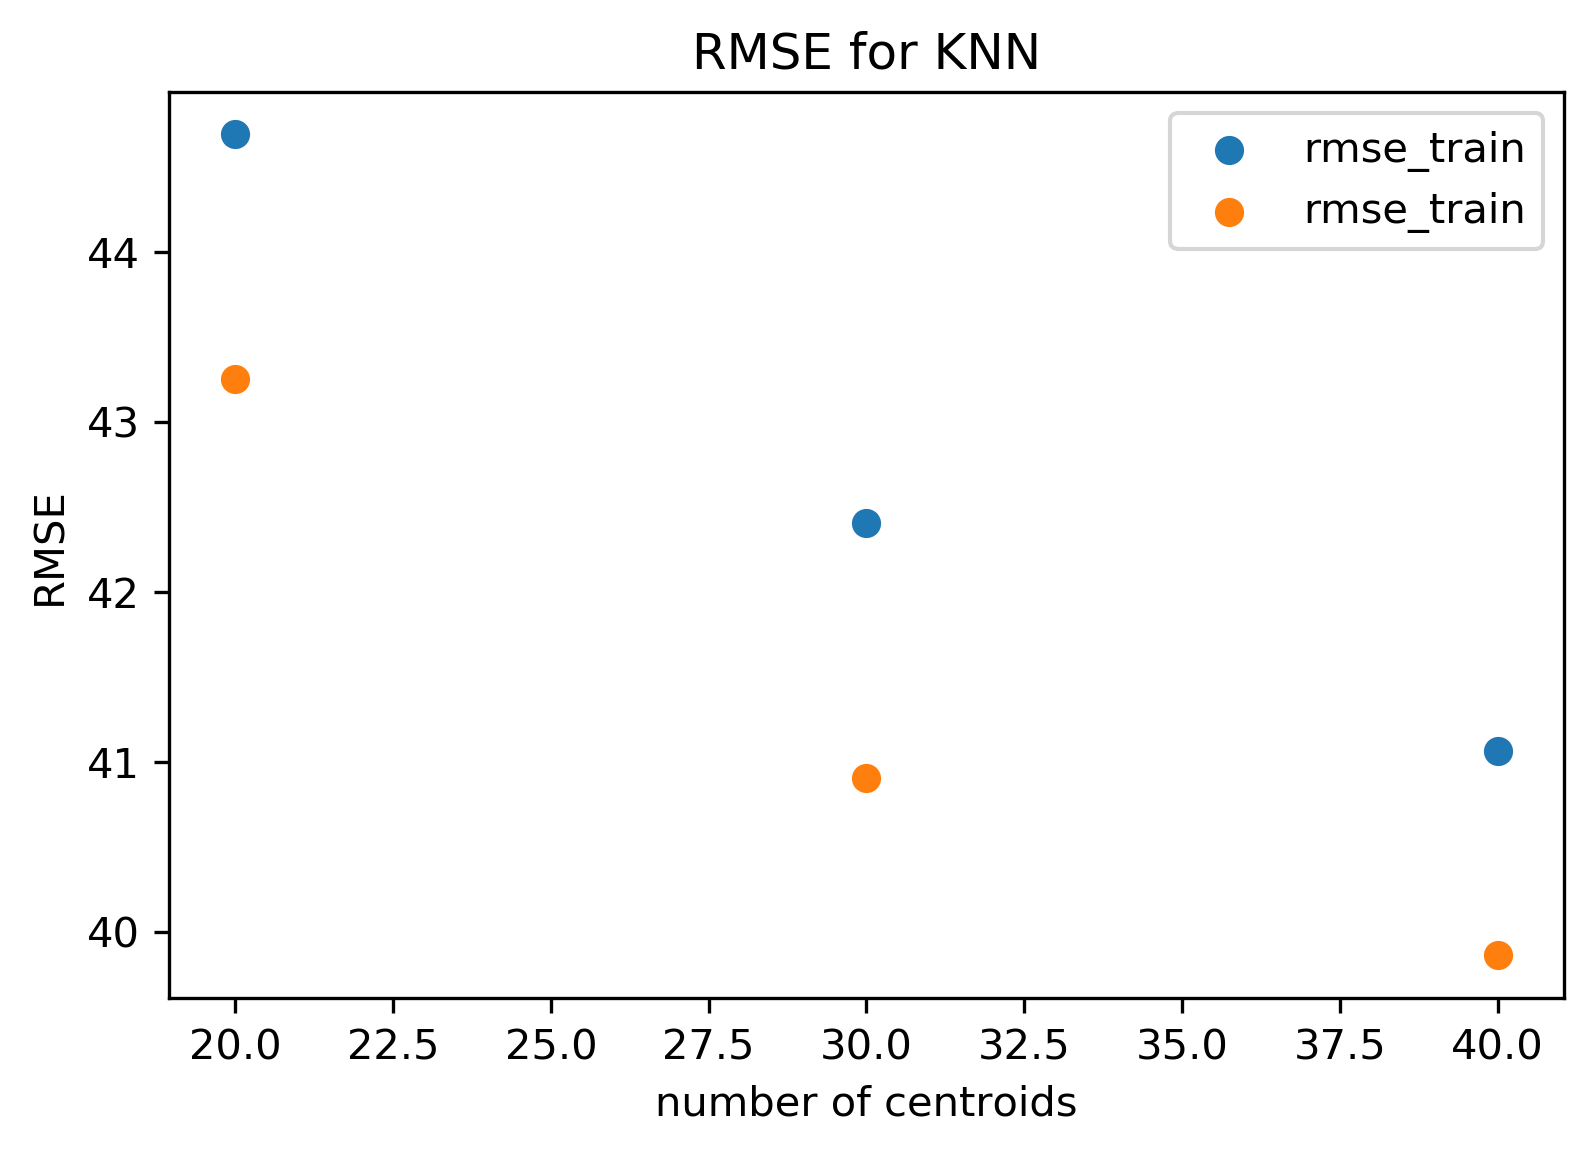

In [20]:
print(rmses_train)
print(rmses_test)

import matplotlib.pyplot as plt

if True:
    plt.figure(dpi=300)
    plt.title('RMSE for KNN')
    plt.scatter([20,30,40], [rmses_train[20][0], rmses_train[30][0], rmses_train[40][0] ], label='rmse_train')
    plt.scatter([20,30,40], [rmses_test[20][0], rmses_test[30][0], rmses_test[40][0] ], label='rmse_train')
    plt.xlabel('number of centroids')
    plt.ylabel('RMSE')
    plt.legend()
    #plt.show()
    plt.savefig('rbfn_plot.png')

In [12]:
rmse = build_model(X_selected_trans, Y_train_valid, X_test_selected_trans, Y_test, ['linear_regression_tp'])
rmse  #45.84108722841299

45.84108722841299

In [13]:
rmse_knn = build_model(X_selected_trans, Y_train_valid, X_test_selected_trans, Y_test, ['KNN'])
rmse_knn #41.41294425130135

41.41294425130135

In [ ]:
rmse_lin_reg = build_model(X_selected_trans, Y_train_valid, X_test_selected_trans, Y_test, ['linear_regression'])
rmse_lin_reg #45.84108722841296

In [14]:
rmse_tree = build_model(X_selected_trans, Y_train_valid, X_test_selected_trans, Y_test, ['tree'])
rmse_tree # 46.1311463097737 !!!


46.1311463097737

In [ ]:
rmse_rf = build_model(X_selected_trans, Y_train_valid, X_test_selected_trans, Y_test, ['random_forest'])
rmse_rf 

In [ ]:
rmse_mlp = build_model(X_selected_trans, Y_train_valid, X_test_selected_trans, Y_test, ['MLperceptron'])
rmse_mlp 

In [15]:
rmse_svm = build_model(X_selected_trans, Y_train_valid, X_test_selected_trans, Y_test, ['SVM'])
rmse_svm # 43.463949029766184

//miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[43.463949029766184,
 [-43.89773021431109,
  {'C': 10, 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf'},
  SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
      kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)]]

In [ ]:
def custom_metric(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))

In [ ]:
def tree_print2(X_train, Y_train, X_test, Y_test ):
    param_grid = {'max_depth':[2,5,10,20],
        'min_impurity_decrease':[0, 0.01, 0.1],
        "min_samples_leaf" : [5,10,20,50],
        'criterion':['mse']}
    Tree = DecisionTreeRegressor()

    grid = GridSearchCV(Tree, param_grid, cv = 5, scoring = M_squared_error)
    grid.fit(X_train,Y_train)

    print (grid.best_score_)
    print (grid.best_params_)
    print (grid.best_estimator_)

    clf = grid.best_estimator_
    clf.fit(X_train,Y_train)
    
    pred_train = clf.predict(X_train[X_train.columns])
    pred_test = clf.predict(X_test[X_train.columns])
    
    return [custom_metric(pred_train, Y_train.values), custom_metric(pred_test,Y_test.values)]

In [ ]:
rmses = tree_print2(X_selected_trans, Y_train_valid, X_test_selected_trans, Y_test)
rmses

In [ ]:
def print_KNN(X_train, Y_train, X_test, Y_test, k_range):
    
    #k_range=list(range(1,31)) + [50,100]
    #k_range= [50,100]
    #k_range=[500,1000]
    
    weight_options = ["uniform"]
    #weight_options = ["distance"]
    param_grid = dict(n_neighbors = k_range, weights = weight_options)
    
    knn = KNeighborsRegressor()
    
    grid = GridSearchCV(knn, param_grid, cv = 5, scoring = M_squared_error)
    grid.fit(X_train,Y_train)

    #print (grid.best_score_)
    #print (grid.best_params_)
    #print (grid.best_estimator_)

    clf = grid.best_estimator_
    clf.fit(X_train,Y_train)

    pred_train = clf.predict(X_train[X_train.columns])
    pred_test = clf.predict(X_test[X_train.columns])
    return [custom_metric(pred_train,Y_train.values),custom_metric(pred_test,Y_test.values)]

In [ ]:
# How vary RMSE according to the number if neighbors, for the train_set and the test_set
rmses_train = list()
rmses_test = list()

for i in range(2, 30):
    [rmse_train, rmse_test] = print_KNN(X_selected_stand, Y_train_valid, X_test_selected_stand, Y_test, list(range(i-1,i)))
    #print(rmse_train, rmse_test)
    rmses_train.append(rmse_train)
    rmses_test.append(rmse_test)




In [ ]:
import matplotlib.pyplot as plt

if False:
    plt.figure(dpi=300)
    plt.title('RMSE for KNN')
    plt.plot(list(range(1,29)), rmses_train, label='rmse_train')
    plt.plot(list(range(1,29)), rmses_test, label='rmse_test')
    plt.xlabel('n_neighbors parameter')
    plt.ylabel('RMSE')
    plt.legend()
    #plt.show()
    plt.savefig('knn_plot.png')

    plt.figure(dpi=300)
    plt.title('RMSE for KNN')
    plt.scatter(list(range(1,29)), rmses_train, label='rmse_train')
    plt.scatter(list(range(1,29)), rmses_test, label='rmse_test')
    plt.xlabel('n_neighbors parameter')
    plt.ylabel('RMSE')
    plt.legend()
    #plt.show()
    plt.savefig('knn_scatter.png')



In [ ]:
def print_SVM(X_train, Y_train, X_test, Y_test, c=10, g='auto', e=0.1 ):
    
    svc = svm.SVR(kernel= 'rbf', C=c, gamma=g, epsilon=e)
    #grid = GridSearchCV(svc, parameters, cv=5,scoring = M_squared_error)
    #grid.fit(X_train,Y_train.values.ravel())
    
    svc.fit(X_train,Y_train.values.ravel())
    pred_train = svc.predict(X_train[X_train.columns])
    pred_test = svc.predict(X_test[X_train.columns])

    #print (grid.best_score_)
    #print (grid.best_params_)
    #print (grid.best_estimator_)


    #clf = grid.best_estimator_
    #clf.fit(X_train,Y_train.values.ravel())

    #pred_train = clf.predict(X_train[X_train.columns])
    #pred_test = clf.predict(X_test[X_train.columns])
    return [custom_metric(pred_train,Y_train.values), custom_metric(pred_test,Y_test.values)]

In [ ]:
rmses_train = list()
rmses_test = list()

for c in [1, 10, 100, 200, 300, 1000]:
    [rmse_train, rmse_test] = print_SVM(X_selected_stand, Y_train_valid, X_test_selected_stand, Y_test, c=c)
    rmses_train.append(rmse_train)
    rmses_test.append(rmse_test)
    print(c, rmse_train, rmse_test)

# Outliers

In [ ]:
#The histrogam below plot the output Y1 for the train-valid set
hist = Y_test.hist(bins=300)



In [ ]:
i = 400
X_selected_outliers = X_selected.loc[list(Y_train_valid['Label']<i)]
Y_train_valid_outliers = Y_train_valid[list(Y_train_valid['Label']<i)]
print(X_selected.shape)
print(X_selected_outliers.shape)



In [ ]:
rmse_lin_reg_outlier = build_model(X_selected_outliers, Y_train_valid_outliers, X_test_selected, Y_test, ['linear_regression'])
rmse_lin_reg_outlier # 45.813509580242254 # with stand, X_test_selected
                    # 46.32600875114827 # with stand, X_test_selected_outlier

In [ ]:
rmse_knn_outlier = build_model(X_selected_outliers, Y_train_valid_outliers, X_test_selected, Y_test, ['KNN'])
rmse_knn_outlier # 41.25390056831065 # with stand, X_test_selected
                # 44.26778845376413  # with stand, X_test_selected_outlier

# Reducing dimentions PCA (after feature selection)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()

pca = PCA(n_components=5)
pca.fit_transform(X_selected)

print(pca.explained_variance_ratio_)
print("pca.explained_variance_ratio_ = ", np.sum(pca.explained_variance_ratio_))


In [ ]:
X_selected_pca = pd.DataFrame(pca.transform(X_selected))
X_test_selected_pca = pd.DataFrame(pca.transform(X_test_selected))
print(X_selected_pca)


In [ ]:
rmse_lin_reg_pca = build_model(X_selected_pca, Y_train_valid, X_test_selected_pca, Y_test, ['linear_regression'])
rmse_lin_reg_pca # 45.813509580242254 # with stand, X_test_selected
                    # 52.12101428226876 # with stand, X_test_selected_pca